In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf


2024-05-13 18:52:40.082187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 18:52:40.082287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 18:52:40.216885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [77]:
df = pd.read_csv('/kaggle/input/finalcsv/final.csv')
df.head()

,Unnamed: 0,ID,Resume_str,Resume_html,Category
0,0,16852973.0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,1,22323967.0,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,2,33176873.0,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,3,27018550.0,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,4,17812897.0,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [49]:
df['Category'].value_counts().keys()[-5:]

Index(['APPAREL', 'DIGITAL-MEDIA', 'AGRICULTURE', 'AUTOMOBILE', 'BPO'], dtype='object', name='Category')

In [50]:
df['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

In [80]:
df = df[(df['Category']!='BPO') &
(df['Category']!='AUTOMOBILE') &
(df['Category']!='AGRICULTURE') &
(df['Category']!='DIGITAL-MEDIA') &
(df['Category']!='ADVOCATE') &
(df['Category']!='TEACHER') &
(df['Category']!='BANKING') & 
(df['Category']!='ARTS') &
(df['Category']!='PUBLIC-RELATIONS') &
(df['Category']!='APPAREL') &
(df['Category']!='AVIATION') &
(df['Category']!='FITNESS')]

In [81]:
df['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    6829
BUSINESS-DEVELOPMENT       120
ACCOUNTANT                 118
CHEF                       118
ENGINEERING                118
FINANCE                    118
SALES                      116
HEALTHCARE                 115
CONSULTANT                 115
CONSTRUCTION               112
HR                         110
DESIGNER                   107
Name: count, dtype: int64

In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(
    num_words=10000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token='<OOV>',
    analyzer=None,
    )

data=list(df['Resume_str'])
tokenizer.fit_on_texts(data)
word_index = tokenizer.index_word
sequences = tokenizer.texts_to_sequences(data)


from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(
    sequences,
    maxlen=1024,
    padding='post',
    truncating='post')


In [96]:
import pickle

with open('/kaggle/working/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [102]:
print(cols)

['ACCOUNTANT', 'BUSINESS-DEVELOPMENT', 'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'ENGINEERING', 'FINANCE', 'HEALTHCARE', 'HR', 'INFORMATION-TECHNOLOGY', 'SALES']


In [4]:
print(f"Max Length {max([len(i) for i in sequences])}")

Max Length 5166


In [31]:
from tqdm import tqdm
embeddings_index = {}
f = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:14, 28512.23it/s]

Found 400000 word vectors.


In [83]:

embeddings_matrix = np.zeros((len(word_index)+1, 100))
for i, word in tqdm(word_index.items()):
    vector = embeddings_index.get(word)
    if vector is not None:
        embeddings_matrix[i] = vector

100%|██████████| 77906/77906 [00:00<00:00, 426328.29it/s]


In [97]:
np.save('/kaggle/working/embeddings_matrix_New',embeddings_matrix)

In [98]:
embeddings_matrix.shape

(77907, 100)

In [100]:
len(word_index)

77906

In [84]:
labels = pd.get_dummies(df['Category'],prefix_sep='_').astype(int)


In [56]:
print(list(labels.columns))

['ACCOUNTANT', 'AVIATION', 'BUSINESS-DEVELOPMENT', 'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR', 'INFORMATION-TECHNOLOGY', 'SALES']


In [85]:
df['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'BUSINESS-DEVELOPMENT',
       'HEALTHCARE', 'SALES', 'CONSULTANT', 'CHEF', 'FINANCE',
       'ENGINEERING', 'ACCOUNTANT', 'CONSTRUCTION'], dtype=object)

In [6]:
labels.iloc[0:1]

,ACCOUNTANT,ADVOCATE,AGRICULTURE,APPAREL,ARTS,AUTOMOBILE,AVIATION,BANKING,BPO,BUSINESS-DEVELOPMENT,...,DIGITAL-MEDIA,ENGINEERING,FINANCE,FITNESS,HEALTHCARE,HR,INFORMATION-TECHNOLOGY,PUBLIC-RELATIONS,SALES,TEACHER
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [86]:
from sklearn.model_selection import train_test_split

X=pd.DataFrame(padded)
Y=pd.DataFrame(labels)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.3, random_state=42, stratify=Y)
xtrain = xtrain.values
xtest = xtest.values
ytrain = ytrain.values
ytest = ytest.values



In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 100, embeddings_initializer=tf.keras.initializers.Constant(embeddings_matrix), trainable=False),
    #tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(256, return_sequences=True)), 
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(labels.shape[1], activation='softmax')
    
    
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
import keras

@keras.saving.register_keras_serializable(package="MyLayers")
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        print(len(input_shape))
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True
    def compute_mask(self, input, input_mask=None):
        return None
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = tf.reshape(tf.matmul(tf.reshape(x, (-1, features_dim)),
                    tf.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b

        eij = tf.keras.activations.tanh(eij)
        a = tf.exp(eij)
        if mask is not None:
            a *= tf.cast(mask, tf.floatx())
        a /= tf.cast(tf.reduce_sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.keras.backend.floatx())
        a = tf.expand_dims(a,-1)
        weighted_input = x * a
        return tf.reduce_sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    def get_config(self):
        config = {
            'step_dim': self.step_dim,
            'W_regularizer': regularizers.serialize(self.W_regularizer),
            'b_regularizer': regularizers.serialize(self.b_regularizer),
            'W_constraint': constraints.serialize(self.W_constraint),
            'b_constraint': constraints.serialize(self.b_constraint),
            'bias': self.bias
        }
        base_config = super(Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [88]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 100, embeddings_initializer=tf.keras.initializers.Constant(embeddings_matrix), trainable=False, input_shape=[1024]),
    #tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(256, return_sequences=True)), 
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional( tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional( tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional( tf.keras.layers.GRU(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    Attention(1024),
    #tf.keras.layers.Bidirectional( tf.keras.layers.GRU(32, return_sequences=False)),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(labels.shape[1], activation='softmax')
    
    
])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 1024, 100)      │     7,790,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 1024, 256)      │       176,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1024, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 1024, 128)      │       123,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 1024, 64)       │        31,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_5 (Attention)         │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129,816 (31.01 MB)

 Trainable params: 339,116 (1.29 MB)

 Non-trainable params: 7,790,700 (29.72 MB)

* check if 100 works equally good
* add weifht decay
* change architecture
* add gru
* change max len

In [89]:
#import tensorflow_addons as tfa


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005), 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [29]:
len(word_index)

45306

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(filepath='/kaggle/working/My_model.weights.h5',
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_weights_only=True,
                                      verbose=1)



In [16]:
keras.__version__

'3.2.1'

In [90]:
model.fit(xtrain,ytrain, validation_data=(xtest, ytest), epochs=100, batch_size=64)#, callbacks=[checkpoint_callback])

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 332ms/step - accuracy: 0.4576 - loss: 1.8311 - val_accuracy: 0.8436 - val_loss: 0.8265
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.8176 - loss: 0.9909 - val_accuracy: 0.8543 - val_loss: 0.5318
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.8433 - loss: 0.5978 - val_accuracy: 0.8559 - val_loss: 0.4657
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.8531 - loss: 0.4626 - val_accuracy: 0.8547 - val_loss: 0.4383
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.8490 - loss: 0.4426 - val_accuracy: 0.8600 - val_loss: 0.4242
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.8583 - loss: 0.4181 - val_accuracy: 0.8588 - val_loss: 0.4319
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.8571 - loss: 0.4179 - val_accuracy: 0.8666 - val_loss: 0.4144
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.8681 - loss: 0.3933 - 

KeyboardInterrupt: 

In [94]:
model.save_weights('/kaggle/working/modelNew.weights.h5')

In [91]:
preds = model.predict(xtest)

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step


In [44]:
cols = labels.columns

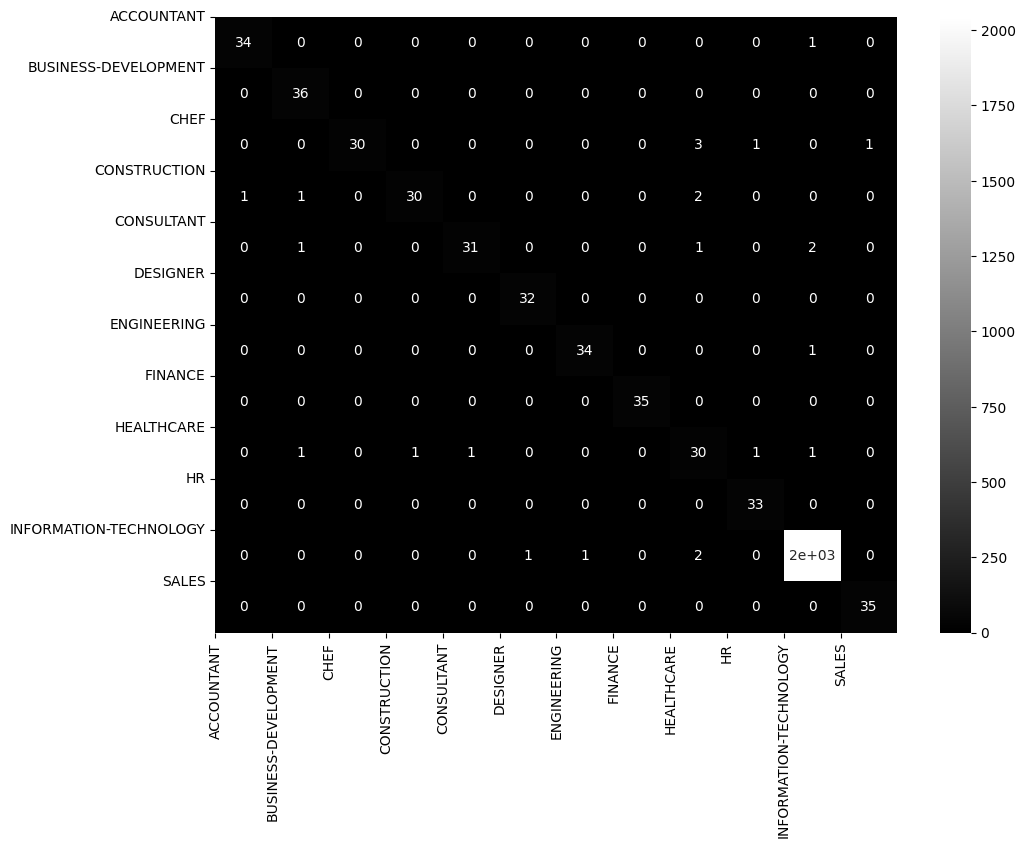

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = list(labels.columns)
plt.figure(figsize=(11,8))
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix( np.argmax(ytest, axis=1),np.argmax(preds, axis=1)),annot=True, cmap='gray')
plt.yticks(ticks =[x for x in range(len(cols))],labels=cols, rotation=0)
plt.xticks(ticks =[x for x in range(len(cols))],labels=cols, rotation=90)

plt.show()

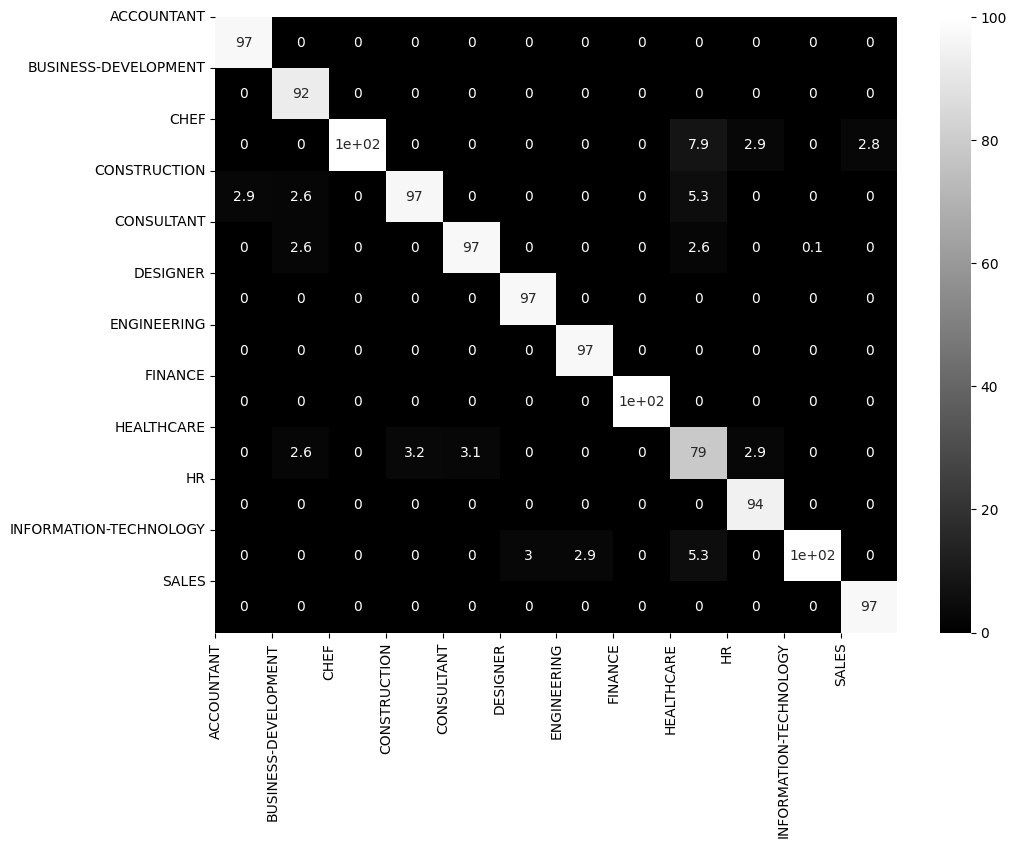

In [93]:
cu = confusion_matrix( np.argmax(ytest, axis=1),np.argmax(preds, axis=1))
cu = np.round((cu/np.sum(cu,axis=0, keepdims=True))*100, 1)

cols = list(labels.columns)
plt.figure(figsize=(11,8))
from sklearn.metrics import confusion_matrix
sns.heatmap(cu,annot=True, cmap='gray')
plt.yticks(ticks =[x for x in range(len(cols))],labels=cols, rotation=0)
plt.xticks(ticks =[x for x in range(len(cols))],labels=cols, rotation=90)

plt.show()

In [71]:
np.unique(np.argmax(ytest, axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([35, 35, 36, 35, 34, 35, 32, 35, 36, 35, 35, 33, 36, 35]))

In [72]:
np.unique(np.argmax(ytrain, axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([83, 82, 84, 83, 78, 80, 75, 83, 82, 82, 80, 77, 84, 81]))

In [64]:
model.evaluate(xtest, ytest)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8446 - loss: 1.3624


[1.4943495988845825, 0.8230562806129456]

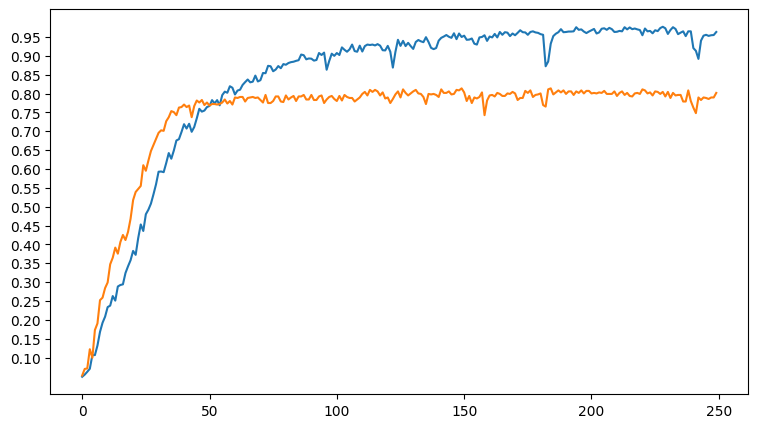

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
results1 =  pd.concat([results,pd.DataFrame(model.history.history)], axis=0).reset_index().drop(columns=['index'])
#results =  pd.DataFrame(model.history.history)
plt.plot(results1['accuracy'])
plt.plot(results1['val_accuracy'])
plt.yticks(np.arange(0.1, 1, 0.05))
plt.show()

In [31]:
labels = pd.get_dummies(df['Category']).astype(int).values
labels.shape

(2484, 24)

In [119]:
val = np.expand_dims(padded[0], axis=0)
print(f"true label: {np.argmax(labels[0])}")
print(f"predicted label: {np.argmax(model(val))}")



true label: 19
predicted label: 19


In [96]:
embeddings_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
model.layers[0](val).numpy().sum()

0.0

In [63]:
dum = tokenizer.sequences_to_texts(padded)

In [74]:
print(f'{dum[0].split()[0]}: {val[0][0]}')

hr: 201


In [77]:
for x in range(len(val[0][:20])):
    print(f'{dum[0].split()[x]}: {val[0][x]}')

hr: 201
administrator: 803
marketing: 35
associate: 233
hr: 201
administrator: 803
summary: 118
dedicated: 910
customer: 20
service: 25
manager: 33
with: 8
15: 731
years: 126
of: 4
experience: 29
in: 6
hospitality: 1723
and: 2
customer: 20


In [10]:
pip install pdfplumber

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 52.9 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pdfplumber

In [14]:
with pdfplumber.open("/kaggle/input/omadpdf/imad_assignment.pdf") as pdf:
    t=' '
    for page in pdf.pages:
        text = page.extract_text()
        t = t+text
    t = t.replace('\n',' ').split()
    

In [18]:
np.expand_dims(t, axis=0)

array([['ASSIGNMENT', 'Teacher:', 'Sir', ..., 'a', 'specific',
        'transaction.']], dtype='<U27')

In [22]:
new_seq = tokenizer.texts_to_sequences([t])
padded_new = pad_sequences(
    new_seq,
    maxlen=1024,
    padding='post',
    truncating='post')

In [ ]:
model = tf.keras.models.load_model('/kaggle/input/my-model/model_weights_best (7) (1024 LEN).keras')


In [2]:
df_data = pd.read_json("ner.json", lines=True)
df_data = df_data.drop(['extras'], axis=1)
df_data['content'] = df_data['content'].str.replace("\n", " ")

In [3]:
df_data.head()

,content,annotation
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [4]:
df_data.iloc[0]['content']

"Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Les

In [34]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])